In [3]:
!wget https://raw.githubusercontent.com/mufaddalhamidofficial/tensorflow_course/main/helper_funcs.py

zsh:1: command not found: wget


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from helper_funcs import create_tensorboard_callback, create_checkpoint_callback, plot_loss_curves, compare_historys, unzip_data, calculate_results
import tensorflow_hub as hub

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
Receiving objects: 100% (39/39), 177.08 MiB | 3.66 MiB/s, done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt   test.txt  train.txt


In [39]:
DIR_NAME = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
DIR_NAME_100 = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"


In [30]:
import io

train_file = io.open(f"{DIR_NAME}train.txt")
train_text = train_file.read()
train_file.close()

In [35]:
def get_data(file_name):
    file = io.open(file_name)
    text = file.read()
    file.close()
    array_of_train = list(map(lambda e: e.split("\n")[1:], text.split("\n###")))
    # array_of_train
    train_data = [
        {
            "paragraph_number": i,
            "line_number": j,
            "target": line.split("\t")[0],
            "text": "\t".join(line.split("\t")[1:]).lower(),
            "total_lines": len(elem) - 1,
        }
        for i, elem in enumerate(array_of_train)
        for j, line in enumerate(elem)
        if line != ""
    ]
    return train_data

In [36]:
train_data = get_data(f"{DIR_NAME}train.txt")
val_data = get_data(f"{DIR_NAME}dev.txt")
test_data = get_data(f"{DIR_NAME}test.txt")
len(train_data), len(val_data), len(test_data)

(180040, 30212, 30135)

In [37]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)
train_df.head(27)

,paragraph_number,line_number,target,text,total_lines
0,0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,12
1,0,1,METHODS,a total of @ patients with primary knee oa wer...,12
2,0,2,METHODS,outcome measures included pain reduction and i...,12
3,0,3,METHODS,pain was assessed using the visual analog pain...,12
4,0,4,METHODS,secondary outcome measures included the wester...,12
5,0,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",12
6,0,6,RESULTS,there was a clinically relevant reduction in t...,12
7,0,7,RESULTS,the mean difference between treatment arms ( @...,12
8,0,8,RESULTS,"further , there was a clinically relevant redu...",12
9,0,9,RESULTS,these differences remained significant at @ we...,12


In [10]:
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

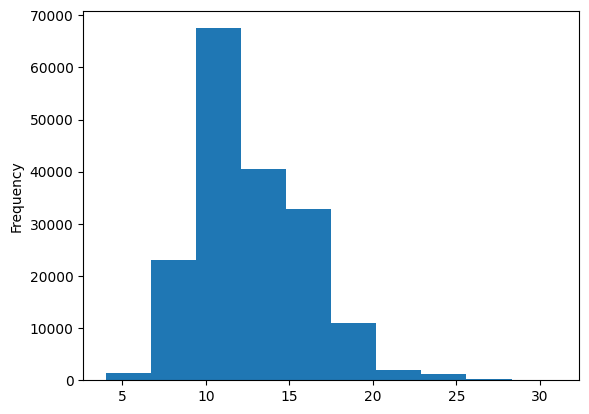

In [11]:
train_df.total_lines.plot.hist()

<Axes: ylabel='Frequency'>

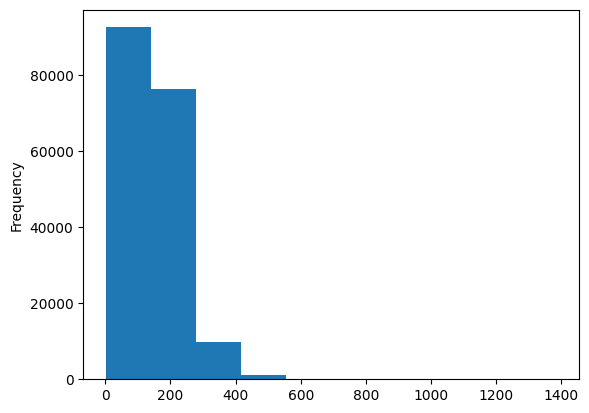

In [12]:
train_df.text.apply(len).plot.hist()

In [13]:
train_sentences = train_df.text.to_numpy()
train_labels = train_df.target.to_numpy()

val_sentences = val_df.text.to_numpy()
val_labels = val_df.target.to_numpy()

test_sentences = test_df.text.to_numpy()
test_labels = test_df.target.to_numpy()

In [14]:
train_sentences

array(['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
       'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
       'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
       ...,
       'both strategies had acceptable side effect profiles , with a low incidence oflaboratory abnormalities and cardiovascular events .',
       'compared with standard statin monotherapy , the combination of statin plus ezetimibe showed greater coronary plaque regression , which might be attributed to cholesterol absorption inhibition-induced aggressive lipid lowering .',
       '( plaque regression with cholesterol abs

## Saving data seprately into 0.1%, 1%, 10%, 100%

In [42]:
# 100%
train_df_100_percent = pd.DataFrame(get_data(f"{DIR_NAME_100}train.txt"))
val_df_100_percent = pd.DataFrame(get_data(f"{DIR_NAME_100}dev.txt"))
test_df_100_percent = pd.DataFrame(get_data(f"{DIR_NAME_100}test.txt"))

In [47]:
train_df_100_percent.columns, train_df_100_percent.shape, val_df_100_percent.shape, test_df_100_percent.shape

(Index(['paragraph_number', 'line_number', 'target', 'text', 'total_lines'], dtype='object'),
 (2211861, 5),
 (28932, 5),
 (29493, 5),
 190653)

In [48]:
max(train_df_100_percent.paragraph_number), max(test_df_100_percent.paragraph_number), max(val_df_100_percent.paragraph_number)

(190653, 2499, 2499)

In [52]:
!mkdir data
!mkdir data/100_percent
!mkdir data/10_percent
!mkdir data/1_percent
!mkdir data/01_percent

In [53]:
train_df_100_percent.to_csv("data/100_percent/train.csv", index=True)
val_df_100_percent.to_csv("data/100_percent/val.csv", index=True)
test_df_100_percent.to_csv("data/100_percent/test.csv", index=True)

In [63]:
train_paragraph_count_10_percent = int(max(train_df_100_percent.paragraph_number) / 10)
train_paragraph_count_1_percent = int(max(train_df_100_percent.paragraph_number) / 100)
train_paragraph_count_01_percent = int(max(train_df_100_percent.paragraph_number) / 1000)

val_paragraph_count_10_percent = int(max(val_df_100_percent.paragraph_number) / 10)
val_paragraph_count_1_percent = int(max(val_df_100_percent.paragraph_number) / 100)
val_paragraph_count_01_percent = int(max(val_df_100_percent.paragraph_number) / 1000)

test_paragraph_count_10_percent = int(max(test_df_100_percent.paragraph_number) / 10)
test_paragraph_count_1_percent = int(max(test_df_100_percent.paragraph_number) / 100)
test_paragraph_count_01_percent = int(max(test_df_100_percent.paragraph_number) / 1000)

In [64]:
train_paragraph_count_10_percent, train_paragraph_count_1_percent, train_paragraph_count_01_percent, val_paragraph_count_10_percent, val_paragraph_count_1_percent, val_paragraph_count_01_percent, test_paragraph_count_10_percent, test_paragraph_count_1_percent, test_paragraph_count_01_percent

(19065, 1906, 190, 249, 24, 2, 249, 24, 2)

In [65]:
train_df_10_percent = train_df_100_percent[train_df_100_percent.paragraph_number <= train_paragraph_count_10_percent]
val_df_10_percent = val_df_100_percent[val_df_100_percent.paragraph_number <= val_paragraph_count_10_percent]
test_df_10_percent = test_df_100_percent[test_df_100_percent.paragraph_number <= test_paragraph_count_10_percent]

train_df_1_percent = train_df_100_percent[train_df_100_percent.paragraph_number <= train_paragraph_count_1_percent]
val_df_1_percent = val_df_100_percent[val_df_100_percent.paragraph_number <= val_paragraph_count_1_percent]
test_df_1_percent = test_df_100_percent[test_df_100_percent.paragraph_number <= test_paragraph_count_1_percent]

train_df_01_percent = train_df_100_percent[train_df_100_percent.paragraph_number <= train_paragraph_count_01_percent]
val_df_01_percent = val_df_100_percent[val_df_100_percent.paragraph_number <= val_paragraph_count_01_percent]
test_df_01_percent = test_df_100_percent[test_df_100_percent.paragraph_number <= test_paragraph_count_01_percent]

train_df_10_percent.shape, val_df_10_percent.shape, test_df_10_percent.shape, train_df_1_percent.shape, val_df_1_percent.shape, test_df_1_percent.shape, train_df_01_percent.shape, val_df_01_percent.shape, test_df_01_percent.shape

((221279, 5),
 (2870, 5),
 (2931, 5),
 (22084, 5),
 (272, 5),
 (306, 5),
 (2177, 5),
 (35, 5),
 (31, 5))

In [66]:
train_df_10_percent.to_csv("data/10_percent/train.csv", index=True)
val_df_10_percent.to_csv("data/10_percent/val.csv", index=True)
test_df_10_percent.to_csv("data/10_percent/test.csv", index=True)

train_df_1_percent.to_csv("data/1_percent/train.csv", index=True)
val_df_1_percent.to_csv("data/1_percent/val.csv", index=True)
test_df_1_percent.to_csv("data/1_percent/test.csv", index=True)

train_df_01_percent.to_csv("data/01_percent/train.csv", index=True)
val_df_01_percent.to_csv("data/01_percent/val.csv", index=True)
test_df_01_percent.to_csv("data/01_percent/test.csv", index=True)

## One hot encode labels

In [15]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_labels.reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
class_names = label_encoder.classes_
classes_count = len(class_names)
classes_count, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Building Models

### Model 0: Naive Bayes (baseline)

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", MultinomialNB()),
    ]
)

model_0.fit(train_sentences, train_labels_encoded)

model_0_preds = model_0.predict(val_sentences)

model_0_results = calculate_results(val_labels_encoded, model_0_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Preparing Data

In [19]:
sentences_lengths = [len(sentence.split()) for sentence in train_sentences]

min(sentences_lengths), max(sentences_lengths), np.mean(sentences_lengths)

(1, 296, 26.338269273494777)

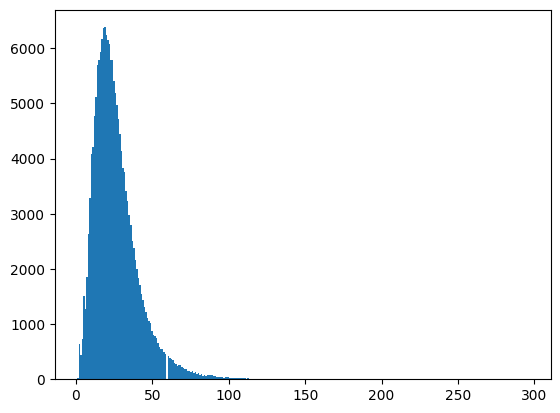

In [20]:
plt.hist(sentences_lengths, bins=300);

In [21]:
seq_len = int(np.percentile(sentences_lengths, 95))
seq_len

55

In [22]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=68000,
    output_sequence_length=seq_len,
)
text_vectorizer.adapt(train_sentences)

2024-02-02 20:11:36.766642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-02 20:11:36.766667: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-02 20:11:36.766676: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-02 20:11:36.766902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 20:11:36.767278: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-02-02 20:11:36.916466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [23]:
random_sentence = random.choice(train_sentences)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([random_sentence])}")


Text:
at the end of operation , the level of serums-@beta protein was ( @ + / - @ ) microg/l in group a , the levels were ( @ + / - @ ) microg/l , ( @ + / - @ ) microg/l , ( @ + / - @ ) microg/l and ( @ + / - @ ) microg/l in group b , c , d and e separately .

Length of text: 73

Vectorized text:
[[   15     2   199     4   701     2   204     4 45794   396    10 16925
      5    13     8     2    93     9 16925 16925 16925     3 16925     5
     13   186   243   187     3   949  2219     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [24]:
embedding = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    mask_zero=True,
)

In [25]:
random_sentence = random.choice(train_sentences)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([random_sentence])}")
print(f"\nEmbedded text:\n{embedding(text_vectorizer([random_sentence]))}")
print(f"\nEmbedded text shape:\n{embedding(text_vectorizer([random_sentence])).shape}")

Text:
the equivalent dose at the sternal level outside the lead apron was @ sv @ per procedure in the call group and @ sv @ per procedure in the no-call group .

Length of text: 32

Vectorized text:
[[    2  1324   131    15     2 11384   204  3076     2   944 27436    10
   5475   160   407     5     2  3001    13     3  5475   160   407     5
      2 22417    13     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Embedded text:
[[[ 0.02384676 -0.00244033  0.01807855 ... -0.04890011 -0.01606014
   -0.04039858]
  [ 0.02351492 -0.0366341  -0.04144968 ... -0.0013437  -0.017751
   -0.01043151]
  [-0.02477622  0.03837499 -0.03490873 ...  0.01612036 -0.00584172
   -0.03515729]
  ...
  [-0.04851186  0.02061776 -0.01671509 ... -0.04347739 -0.04505236
   -0.03235161]
  [-0.04851186  0.02061776 -0.01671509 ... -0.04347739 -0.04505236
   -0.03235161]
  [-0.04851186  0.020617

In [29]:
len(train_sentences)

180040

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [27]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 1: Conv1D

In [28]:
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=68000,
    output_sequence_length=seq_len,
)

text_vectorizer.adapt(train_sentences)

embedding = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    mask_zero=True,
)

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', padding="same")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(classes_count, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_1_history = model_1.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)),
)

model_1_preds = tf.argmax(model_1.predict(val_sentences), axis=1)

model_1_results = calculate_results(val_labels_encoded, model_1_preds)

plot_loss_curves(model_1_history)

model_1_results

Epoch 1/3
 924/5627 [===>..........................] - ETA: 2:26 - loss: 0.8299 - accuracy: 0.6790

KeyboardInterrupt: 

### Model 2: Feature extraction with pretrained token embeddings

In [ ]:
hub_embedding = hub.KerasLayer(
    "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
    trainable=False,
    name="universal_sentence_encoder",
)

In [32]:
random_sentence = random.choice(train_sentences)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nEmbedded text:\n{hub_embedding([random_sentence])}")

Text:
during the two periods and compared to controls , high-density lipoprotein cholesterol and triglycerides were not significantly different .

Length of text: 19

Embedded text:
[[-4.54315469e-02 -3.67806591e-02  2.18035188e-02  4.32892367e-02
  -3.59709165e-03  1.06786350e-02  6.99072778e-02 -4.83445264e-02
  -2.63267867e-02  5.14000468e-02  8.44996497e-02 -6.31028116e-02
  -5.01183048e-02 -7.64230127e-03 -7.77617618e-02 -1.84436254e-02
  -8.55790600e-02  3.70359756e-02  5.74096590e-02  1.37062138e-02
   5.17521277e-02  7.00609088e-02 -5.46711832e-02 -7.01555014e-02
   4.99954000e-02 -6.88758790e-02 -1.79268140e-02  8.57216045e-02
  -2.74398513e-02 -1.37761571e-02 -4.57035787e-02  6.91264421e-02
   4.78846356e-02  6.35390282e-02  1.01303756e-02 -3.12840939e-02
  -2.28292849e-02 -4.82632406e-02 -1.99225470e-02  5.89154437e-02
   4.56418246e-02  2.15890110e-02  2.80948598e-02 -2.66198553e-02
  -4.47769053e-02 -1.35349212e-02 -7.35215377e-03  2.81769652e-02
  -4.00534905e-02 -2.67344

Epoch 1/3
562/562 [==============================] - 40s 69ms/step - loss: 0.9117 - accuracy: 0.6527 - val_loss: 0.8105 - val_accuracy: 0.6868
Epoch 2/3
562/562 [==============================] - 40s 70ms/step - loss: 0.7853 - accuracy: 0.6933 - val_loss: 0.7834 - val_accuracy: 0.6965
Epoch 3/3
945/945 [==============================] - 99s 104ms/step


{'accuracy': 69.70740103270224,
 'precision': 0.6965786818178956,
 'recall': 0.6970740103270223,
 'f1': 0.6938412679409116}

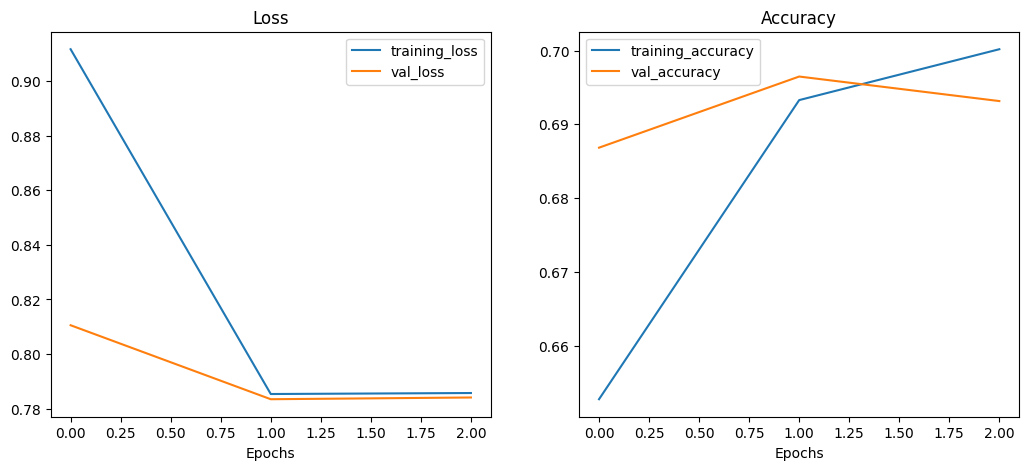

In [33]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = hub_embedding(inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(classes_count, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_2_history = model_2.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset)),
)

model_2_preds = tf.argmax(model_2.predict(val_sentences), axis=1)
model_2_results = calculate_results(val_labels_encoded, model_2_preds)

plot_loss_curves(model_2_history)

model_2_results

### Model 3: Conv1D with character embeddings

In [34]:
train_chars = [" ".join(list(sentence)) for sentence in train_sentences]
val_chars = [" ".join(list(sentence)) for sentence in val_sentences]
test_chars = [" ".join(list(sentence)) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [35]:
char_lens = [len(sentence) for sentence in train_sentences]

min(char_lens), np.mean(char_lens), max(char_lens)

(1, 149.3662574983337, 1386)

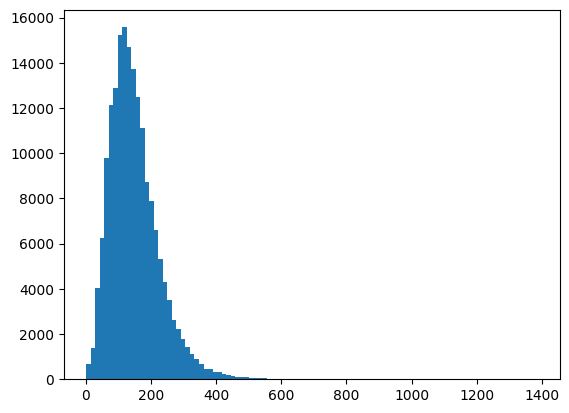

In [36]:
plt.hist(char_lens, bins=100);

In [37]:
seq_char_len = int(np.percentile(char_lens, 90))
seq_char_len

247

In [38]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [39]:
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=seq_char_len,
    # standardize=None,
)

char_vectorizer.adapt(train_chars)

In [40]:
random_sentence = random.choice(train_chars)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nVectorized text:\n{char_vectorizer([random_sentence])}")


Text:
t h e r e   w e r e   @   p a t i e n t s   (   m e a n   a g e   @   @   y e a r s   ,   @   e y e s   )   i n   g r o u p   @   a n d   @   p a t i e n t s   (   m e a n   a g e   @   @   y e a r s   ,   @   e y e s   )   i n   g r o u p   @   .

Length of text: 91

Vectorized text:
[[ 3 13  2  8  2 20  2  8  2 14  5  3  4  2  6  3  9 15  2  5  6  5 18  2
  19  2  5  8  9  2 19  2  9  4  6 18  8  7 16 14  5  6 10 14  5  3  4  2
   6  3  9 15  2  5  6  5 18  2 19  2  5  8  9  2 19  2  9  4  6 18  8  7
  16 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  

In [41]:
char_embedding = tf.keras.layers.Embedding(
    input_dim=len(char_vectorizer.get_vocabulary()),
    output_dim=25,
    mask_zero=True,
)

In [42]:
random_sentence = random.choice(train_chars)

print(f"Text:\n{random_sentence}")
print(f"\nLength of text: {len(random_sentence.split())}")
print(f"\nEmbedded text:\n{char_embedding(char_vectorizer([random_sentence]))}")
print(f"\nEmbedded text shape:\n{char_embedding(char_vectorizer([random_sentence])).shape}")


Text:
t h e   a i m   o f   t h i s   p r o s p e c t i v e   n o n - b l i n d   r a n d o m i s e d   s t u d y   w a s   t o   e v a l u a t e   w o u n d   h e a l i n g   a n d   c o m p l i c a t i o n s   i n   r e l a t i o n   t o   s k i n   i n c i s i o n   c l o s u r e   w i t h   e i t h e r   c o n v e n t i o n a l   s u t u r e   o r   m e t a l   s t a p l e s   .

Length of text: 162

Embedded text:
[[[-0.02253883  0.02093328 -0.03990573 ...  0.00464516 -0.00855722
   -0.03827497]
  [ 0.02704776  0.03134878  0.01234186 ... -0.03166336  0.00893075
   -0.04374275]
  [-0.00455092 -0.00954156 -0.00365856 ... -0.01131952 -0.00333816
    0.03017766]
  ...
  [-0.00229722 -0.02604413 -0.01689112 ... -0.03257817 -0.02615291
    0.03609853]
  [-0.00229722 -0.02604413 -0.01689112 ... -0.03257817 -0.02615291
    0.03609853]
  [-0.00229722 -0.02604413 -0.01689112 ... -0.03257817 -0.02615291
    0.03609853]]]

Embedded text shape:
(1, 247, 25)


In [43]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

Epoch 1/3
562/562 [==============================] - 20s 33ms/step - loss: 1.2505 - accuracy: 0.4900 - val_loss: 1.0433 - val_accuracy: 0.5798
Epoch 2/3
562/562 [==============================] - 14s 26ms/step - loss: 1.0151 - accuracy: 0.5879 - val_loss: 0.9448 - val_accuracy: 0.6193
Epoch 3/3
945/945 [==============================] - 2s 2ms/step


{'accuracy': 64.65642790943996,
 'precision': 0.638750483708529,
 'recall': 0.6465642790943996,
 'f1': 0.6364899364559403}

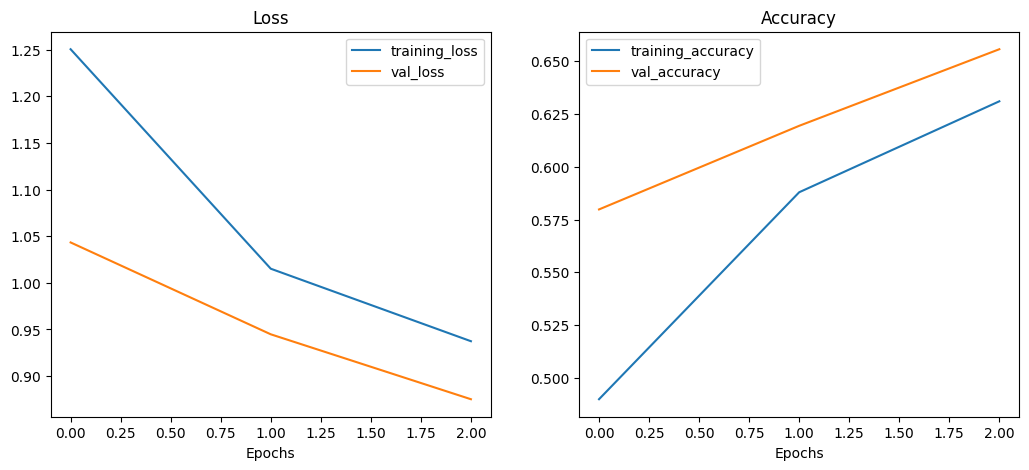

In [44]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = tf.keras.layers.Conv1D(64, 5, activation="relu")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(classes_count, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

model_3_history = model_3.fit(
    train_char_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset)),
)

model_3_preds = tf.argmax(model_3.predict(val_char_dataset), axis=1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)

plot_loss_curves(model_3_history)

model_3_results

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [45]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [47]:
# 1. Setup token inputs/model
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = hub_embedding(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - adding in dropout
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(classes_count, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name="model_4_token_and_char_embeddings",
)

# 6. Compile model
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)


model_4_history = model_4.fit(
    train_char_token_dataset,
    epochs=5,
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1 * len(val_char_token_dataset)),
)

model_4_preds = tf.argmax(model_4.predict(val_char_token_dataset), axis=1)
model_4_results = calculate_results(val_labels_encoded, model_4_preds)

plot_loss_curves(model_4_history)

Epoch 1/5


2024-02-02 20:00:35.119179: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'


145/562 [======>.......................] - ETA: 4:01 - loss: 1.1436 - accuracy: 0.5422

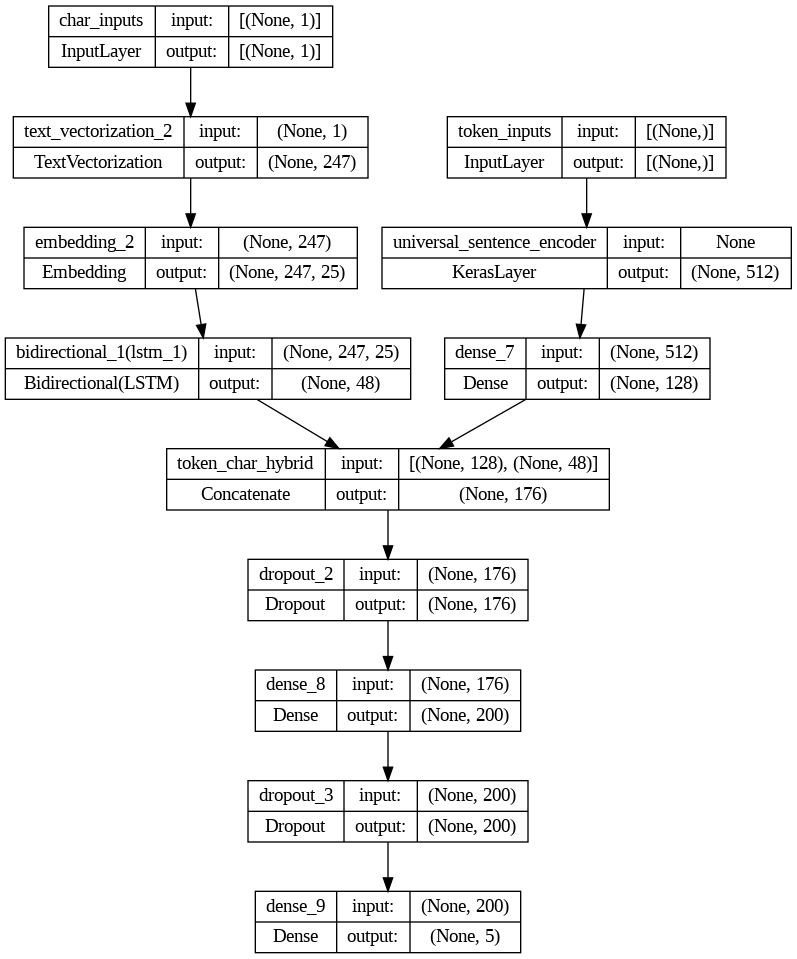

In [ ]:
tf.keras.utils.plot_model(model_4, show_shapes=True)

### Model 5: Transfer learning with pretrained token embedding + character embedding + positional embedding

#### Creating position embeddings

In [ ]:
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:30], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(30, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
train_df["total_lines"].value_counts()

total_lines
12    24456
11    23639
13    22125
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

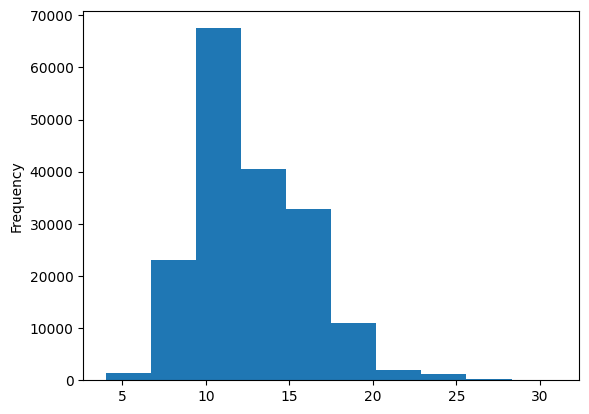

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
np.percentile(train_df['total_lines'], 95)

19.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:20], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

In [ ]:
from tensorflow.keras import layers

embedding = tf.keras.layers.Embedding(
    input_dim=len(text_vectorizer.get_vocabulary()),
    output_dim=128,
    mask_zero=True,
)

token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embedding = embedding(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

total_lines_inputs = layers.Input(shape=(20,), name='total_lines_inputs')
total_lines_outputs = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_outputs)

token_char_concatenate = layers.Concatenate(name="token_char_concatenate")([token_model.output, char_model.output])

drop_out = layers.Dense(256, activation='relu')(token_char_concatenate)
drop_out = layers.Dropout(0.5)(drop_out)

final_concatenate = layers.Concatenate(name='final_concatenate')([drop_out, line_number_model.output, total_lines_model.output])

outputs = layers.Dense(5, activation='softmax', name='output_layer')(final_concatenate)

model_5 = tf.keras.Model([token_model.input, char_model.input, line_number_model.input, total_lines_model.input], outputs)

TypeError: Expected string passed to parameter 'y' of op 'NotEqual', got 0 of type 'int' instead. Error: Expected string, but got 0 of type 'int'.

In [ ]:
model_5.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 text_vectorization_4 (Text  (None, 247)                  0         ['char_inputs[0][0]']         
 Vectorization)                                                                                   
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

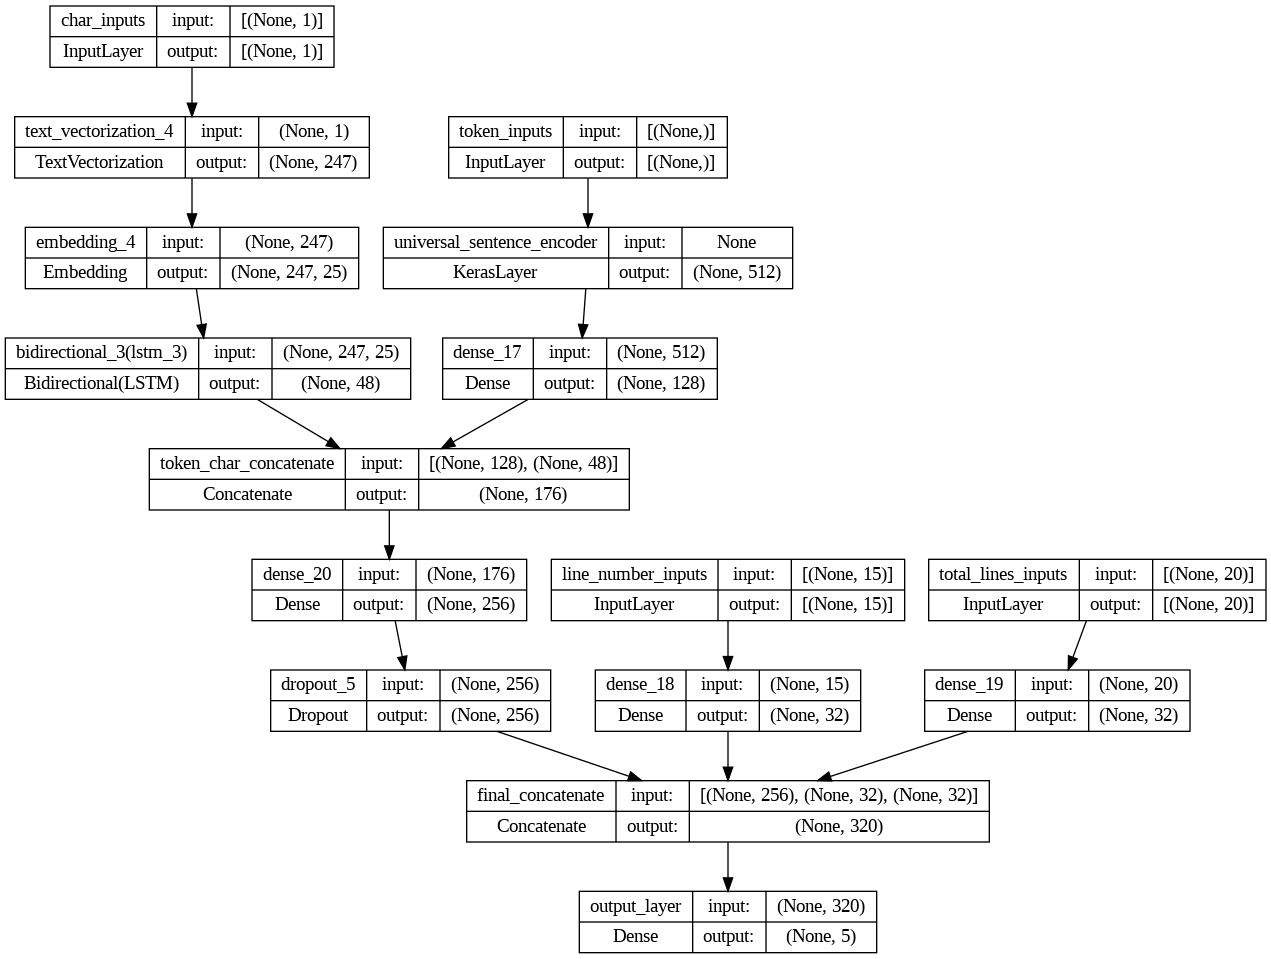

In [ ]:
tf.keras.utils.plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices([train_sentences,
                                                                train_chars,
                                                                train_line_numbers_one_hot,
                                                                train_total_lines_one_hot])
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Data.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices([val_sentences,
                                                              val_chars,
                                                              val_line_numbers_one_hot,
                                                              val_total_lines_one_hot])
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Data.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices([test_sentences,
                                                              test_chars,
                                                              test_line_numbers_one_hot,
                                                              test_total_lines_one_hot])
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Data.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

NameError: name 'train_char_token_pos_data' is not defined